# Method 7 - Best Ideas DGTW Select

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Intra-Cap Portfolio Weight per Shumway, Szefler, Yuan 2009

%store -r cap_exp_ret

valid_data = valid_data.merge(cap_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')[
    'institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_beg_pos = p.beg_port.iloc[1:].resample('M', level=0).apply(epd.take_first)
dgtw = crsp.get_dgtw_returns(list(set(best_ideas['fsym_id'].dropna())),
                    best_ideas['datadate'].min(), pd.datetime(2018, 12, 31))
dgtw_pivot = pd.pivot_table(dgtw, index='datadate', columns='fsym_id', values='total_return')
dgtw_cont = monthly_beg_pos.mul(dgtw_pivot, axis=1, level=0).sum(axis=1)

monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - dgtw_cont).dropna()
monthly_return.name = 'port_return'

## Plot Performance

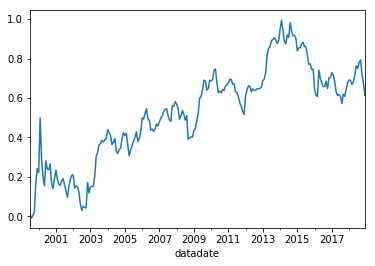

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.242032
2000-12-31   -0.040113
2001-12-31    0.012583
2002-12-31   -0.074525
2003-12-31    0.245947
2004-12-31    0.022718
2005-12-31    0.001304
2006-12-31    0.022735
2007-12-31    0.084645
2008-12-31   -0.114367
2009-12-31    0.206686
2010-12-31   -0.014704
2011-12-31   -0.089689
2012-12-31    0.091956
2013-12-31    0.142234
2014-12-31    0.005626
2015-12-31   -0.081801
2016-12-31   -0.023845
2017-12-31   -0.015215
2018-12-31   -0.039145
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     60.33
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.74e-35
Time:                        21:59:08   Log-Likelihood:                 548.97
No. Observations:                 234   AIC:                            -1088.
Df Residuals:                     229   BIC:                            -1071.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.002      1.512      0.132      -0.001       0.006
mktrf          0.0651      0.044      1.490      0.138      -0.021       0.151
me             0.4240      0.051      8.345      0.000       0.324       0.524
ia            -0.1708      0.077     -2.212      0.028      -0.323      -0.019
roe           -0.3881      0.066     -5.872      0.000      -0.518      -0.258
==============================================================================
Omnibus:                       39.995   Durbin-Watson:                   2.209
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.999
Skew:                           0.811   Prob(JB):                     4.72e-20
Kurtosis:                       5.549   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     12.48
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.38e-09
Time:                        21:59:08   Log-Likelihood:                 548.97
No. Observations:                 234   AIC:                            -1088.
Df Residuals:                     229   BIC:                            -1071.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.002      1.607      0.108      -0.001       0.005
mktrf          0.0651      0.056      1.155      0.248      -0.045       0.175
me             0.4240      0.151      2.814      0.005       0.129       0.719
ia            -0.1708      0.167     -1.020      0.308      -0.499       0.157
roe           -0.3881      0.106     -3.652      0.000      -0.596      -0.180
==============================================================================
Omnibus:                       39.995   Durbin-Watson:                   2.209
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.999
Skew:                           0.811   Prob(JB):                     4.72e-20
Kurtosis:                       5.549   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     13.73
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.74e-10
Time:                        21:59:08   Log-Likelihood:                 548.97
No. Observations:                 234   AIC:                            -1088.
Df Residuals:                     229   BIC:                            -1071.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      1.615      0.106      -0.001       0.005
mktrf          0.0651      0.049      1.337      0.181      -0.030       0.161
me             0.4240      0.167      2.541      0.011       0.097       0.751
ia            -0.1708      0.150     -1.142      0.253      -0.464       0.122
roe           -0.3881      0.112     -3.471      0.001      -0.607      -0.169
==============================================================================
Omnibus:                       39.995   Durbin-Watson:                   2.209
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.999
Skew:                           0.811   Prob(JB):                     4.72e-20
Kurtosis:                       5.549   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     70.25
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.04e-44
Time:                        21:59:08   Log-Likelihood:                 573.86
No. Observations:                 234   AIC:                            -1136.
Df Residuals:                     228   BIC:                            -1115.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      1.754      0.081      -0.000       0.005
mktrf          0.1103      0.039      2.798      0.006       0.033       0.188
smb            0.3557      0.052      6.835      0.000       0.253       0.458
hml           -0.2290      0.061     -3.732      0.000      -0.350      -0.108
rmw           -0.4769      0.069     -6.875      0.000      -0.614      -0.340
cma            0.2714      0.088      3.078      0.002       0.098       0.445
==============================================================================
Omnibus:                       26.373   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.770
Skew:                           0.538   Prob(JB):                     2.85e-13
Kurtosis:                       5.184   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     39.84
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.47e-29
Time:                        21:59:08   Log-Likelihood:                 573.86
No. Observations:                 234   AIC:                            -1136.
Df Residuals:                     228   BIC:                            -1115.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      2.090      0.037       0.000       0.005
mktrf          0.1103      0.039      2.830      0.005       0.034       0.187
smb            0.3557      0.094      3.777      0.000       0.171       0.540
hml           -0.2290      0.101     -2.274      0.023      -0.426      -0.032
rmw           -0.4769      0.093     -5.107      0.000      -0.660      -0.294
cma            0.2714      0.115      2.358      0.018       0.046       0.497
==============================================================================
Omnibus:                       26.373   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.770
Skew:                           0.538   Prob(JB):                     2.85e-13
Kurtosis:                       5.184   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     43.79
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.54e-31
Time:                        21:59:09   Log-Likelihood:                 573.86
No. Observations:                 234   AIC:                            -1136.
Df Residuals:                     228   BIC:                            -1115.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      2.189      0.029       0.000       0.005
mktrf          0.1103      0.039      2.824      0.005       0.034       0.187
smb            0.3557      0.109      3.260      0.001       0.142       0.569
hml           -0.2290      0.102     -2.246      0.025      -0.429      -0.029
rmw           -0.4769      0.097     -4.905      0.000      -0.668      -0.286
cma            0.2714      0.103      2.648      0.008       0.070       0.472
==============================================================================
Omnibus:                       26.373   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.770
Skew:                           0.538   Prob(JB):                     2.85e-13
Kurtosis:                       5.184   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     61.17
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.33e-35
Time:                        21:59:09   Log-Likelihood:                 549.80
No. Observations:                 234   AIC:                            -1090.
Df Residuals:                     229   BIC:                            -1072.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.002      0.355      0.723      -0.003       0.004
mktrf          0.2082      0.040      5.194      0.000       0.129       0.287
smb            0.5268      0.050     10.532      0.000       0.428       0.625
hml           -0.1707      0.050     -3.435      0.001      -0.269      -0.073
umd            0.0079      0.033      0.244      0.808      -0.056       0.072
==============================================================================
Omnibus:                       45.070   Durbin-Watson:                   2.164
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              108.329
Skew:                           0.881   Prob(JB):                     3.00e-24
Kurtosis:                       5.830   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     17.66
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.19e-12
Time:                        21:59:09   Log-Likelihood:                 549.80
No. Observations:                 234   AIC:                            -1090.
Df Residuals:                     229   BIC:                            -1072.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      0.390      0.697      -0.002       0.003
mktrf          0.2082      0.039      5.315      0.000       0.131       0.285
smb            0.5268      0.112      4.714      0.000       0.308       0.746
hml           -0.1707      0.083     -2.047      0.041      -0.334      -0.007
umd            0.0079      0.057      0.140      0.889      -0.104       0.120
==============================================================================
Omnibus:                       45.070   Durbin-Watson:                   2.164
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              108.329
Skew:                           0.881   Prob(JB):                     3.00e-24
Kurtosis:                       5.830   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     18.78
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.28e-13
Time:                        21:59:09   Log-Likelihood:                 549.80
No. Observations:                 234   AIC:                            -1090.
Df Residuals:                     229   BIC:                            -1072.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      0.393      0.695      -0.002       0.003
mktrf          0.2082      0.037      5.671      0.000       0.136       0.280
smb            0.5268      0.114      4.610      0.000       0.303       0.751
hml           -0.1707      0.077     -2.214      0.027      -0.322      -0.020
umd            0.0079      0.065      0.122      0.903      -0.120       0.136
==============================================================================
Omnibus:                       45.070   Durbin-Watson:                   2.164
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              108.329
Skew:                           0.881   Prob(JB):                     3.00e-24
Kurtosis:                       5.830   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     39.30
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.04e-20
Time:                        21:59:09   Log-Likelihood:                 263.06
No. Observations:                 120   AIC:                            -516.1
Df Residuals:                     115   BIC:                            -502.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.003      1.487      0.140      -0.001       0.009
mktrf          0.0576      0.071      0.810      0.420      -0.083       0.199
me             0.5219      0.070      7.426      0.000       0.383       0.661
ia            -0.2674      0.110     -2.430      0.017      -0.485      -0.049
roe           -0.3329      0.097     -3.417      0.001      -0.526      -0.140
==============================================================================
Omnibus:                       11.381   Durbin-Watson:                   2.273
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               13.135
Skew:                           0.587   Prob(JB):                      0.00141
Kurtosis:                       4.116   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     9.644
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.24e-07
Time:                        21:59:09   Log-Likelihood:                 263.06
No. Observations:                 120   AIC:                            -516.1
Df Residuals:                     115   BIC:                            -502.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.003      1.531      0.126      -0.001       0.009
mktrf          0.0576      0.091      0.636      0.525      -0.120       0.235
me             0.5219      0.171      3.059      0.002       0.188       0.856
ia            -0.2674      0.223     -1.200      0.230      -0.704       0.169
roe           -0.3329      0.162     -2.059      0.039      -0.650      -0.016
==============================================================================
Omnibus:                       11.381   Durbin-Watson:                   2.273
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               13.135
Skew:                           0.587   Prob(JB):                      0.00141
Kurtosis:                       4.116   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     12.01
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.44e-08
Time:                        21:59:09   Log-Likelihood:                 263.06
No. Observations:                 120   AIC:                            -516.1
Df Residuals:                     115   BIC:                            -502.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.003      1.537      0.124      -0.001       0.009
mktrf          0.0576      0.084      0.686      0.493      -0.107       0.222
me             0.5219      0.192      2.723      0.006       0.146       0.897
ia            -0.2674      0.200     -1.334      0.182      -0.660       0.125
roe           -0.3329      0.174     -1.912      0.056      -0.674       0.008
==============================================================================
Omnibus:                       11.381   Durbin-Watson:                   2.273
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               13.135
Skew:                           0.587   Prob(JB):                      0.00141
Kurtosis:                       4.116   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     52.03
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.48e-28
Time:                        21:59:09   Log-Likelihood:                 282.66
No. Observations:                 120   AIC:                            -553.3
Df Residuals:                     114   BIC:                            -536.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0050      0.002      2.158      0.033       0.000       0.010
mktrf          0.1285      0.064      2.008      0.047       0.002       0.255
smb            0.4466      0.072      6.162      0.000       0.303       0.590
hml           -0.3160      0.089     -3.558      0.001      -0.492      -0.140
rmw           -0.3868      0.105     -3.693      0.000      -0.594      -0.179
cma            0.2969      0.115      2.587      0.011       0.070       0.524
==============================================================================
Omnibus:                        7.211   Durbin-Watson:                   2.280
Prob(Omnibus):                  0.027   Jarque-Bera (JB):               11.150
Skew:                           0.217   Prob(JB):                      0.00379
Kurtosis:                       4.429   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     47.32
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.89e-26
Time:                        21:59:09   Log-Likelihood:                 282.66
No. Observations:                 120   AIC:                            -553.3
Df Residuals:                     114   BIC:                            -536.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0050      0.002      3.201      0.001       0.002       0.008
mktrf          0.1285      0.058      2.203      0.028       0.014       0.243
smb            0.4466      0.123      3.633      0.000       0.206       0.688
hml           -0.3160      0.137     -2.301      0.021      -0.585      -0.047
rmw           -0.3868      0.149     -2.598      0.009      -0.679      -0.095
cma            0.2969      0.145      2.047      0.041       0.013       0.581
==============================================================================
Omnibus:                        7.211   Durbin-Watson:                   2.280
Prob(Omnibus):                  0.027   Jarque-Bera (JB):               11.150
Skew:                           0.217   Prob(JB):                      0.00379
Kurtosis:                       4.429   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     71.45
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.65e-33
Time:                        21:59:09   Log-Likelihood:                 282.66
No. Observations:                 120   AIC:                            -553.3
Df Residuals:                     114   BIC:                            -536.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0050      0.001      3.608      0.000       0.002       0.008
mktrf          0.1285      0.059      2.168      0.030       0.012       0.245
smb            0.4466      0.141      3.170      0.002       0.170       0.723
hml           -0.3160      0.144     -2.190      0.029      -0.599      -0.033
rmw           -0.3868      0.168     -2.301      0.021      -0.716      -0.057
cma            0.2969      0.120      2.469      0.014       0.061       0.533
==============================================================================
Omnibus:                        7.211   Durbin-Watson:                   2.280
Prob(Omnibus):                  0.027   Jarque-Bera (JB):               11.150
Skew:                           0.217   Prob(JB):                      0.00379
Kurtosis:                       4.429   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     49.97
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.64e-24
Time:                        21:59:09   Log-Likelihood:                 271.79
No. Observations:                 120   AIC:                            -533.6
Df Residuals:                     115   BIC:                            -519.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.002      1.354      0.179      -0.002       0.008
mktrf          0.2346      0.058      4.025      0.000       0.119       0.350
smb            0.5783      0.066      8.715      0.000       0.447       0.710
hml           -0.2252      0.066     -3.388      0.001      -0.357      -0.094
umd            0.0287      0.041      0.700      0.486      -0.053       0.110
==============================================================================
Omnibus:                       15.943   Durbin-Watson:                   2.380
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.923
Skew:                           0.694   Prob(JB):                     1.74e-05
Kurtosis:                       4.568   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     19.86
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.87e-12
Time:                        21:59:09   Log-Likelihood:                 271.79
No. Observations:                 120   AIC:                            -533.6
Df Residuals:                     115   BIC:                            -519.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.002      1.794      0.073      -0.000       0.007
mktrf          0.2346      0.056      4.169      0.000       0.124       0.345
smb            0.5783      0.113      5.115      0.000       0.357       0.800
hml           -0.2252      0.112     -2.003      0.045      -0.446      -0.005
umd            0.0287      0.061      0.471      0.638      -0.091       0.148
==============================================================================
Omnibus:                       15.943   Durbin-Watson:                   2.380
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.923
Skew:                           0.694   Prob(JB):                     1.74e-05
Kurtosis:                       4.568   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     26.16
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.97e-15
Time:                        21:59:09   Log-Likelihood:                 271.79
No. Observations:                 120   AIC:                            -533.6
Df Residuals:                     115   BIC:                            -519.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.002      2.000      0.045    6.55e-05       0.006
mktrf          0.2346      0.052      4.484      0.000       0.132       0.337
smb            0.5783      0.114      5.076      0.000       0.355       0.802
hml           -0.2252      0.112     -2.004      0.045      -0.445      -0.005
umd            0.0287      0.067      0.428      0.668      -0.103       0.160
==============================================================================
Omnibus:                       15.943   Durbin-Watson:                   2.380
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.923
Skew:                           0.694   Prob(JB):                     1.74e-05
Kurtosis:                       4.568   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     22.01
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.45e-13
Time:                        21:59:09   Log-Likelihood:                 313.46
No. Observations:                 114   AIC:                            -616.9
Df Residuals:                     109   BIC:                            -603.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.002     -0.388      0.699      -0.004       0.003
mktrf          0.1741      0.047      3.741      0.000       0.082       0.266
me             0.0569      0.072      0.791      0.430      -0.086       0.199
ia             0.0482      0.100      0.484      0.629      -0.149       0.246
roe           -0.4922      0.088     -5.622      0.000      -0.666      -0.319
==============================================================================
Omnibus:                       12.568   Durbin-Watson:                   1.807
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               14.115
Skew:                           0.681   Prob(JB):                     0.000861
Kurtosis:                       4.057   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     28.51
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.26e-16
Time:                        21:59:09   Log-Likelihood:                 313.46
No. Observations:                 114   AIC:                            -616.9
Df Residuals:                     109   BIC:                            -603.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.001     -0.440      0.660      -0.003       0.002
mktrf          0.1741      0.044      3.986      0.000       0.088       0.260
me             0.0569      0.053      1.066      0.287      -0.048       0.161
ia             0.0482      0.113      0.427      0.669      -0.173       0.270
roe           -0.4922      0.121     -4.080      0.000      -0.729      -0.256
==============================================================================
Omnibus:                       12.568   Durbin-Watson:                   1.807
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               14.115
Skew:                           0.681   Prob(JB):                     0.000861
Kurtosis:                       4.057   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     35.13
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.90e-19
Time:                        21:59:09   Log-Likelihood:                 313.46
No. Observations:                 114   AIC:                            -616.9
Df Residuals:                     109   BIC:                            -603.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.001     -0.420      0.675      -0.003       0.002
mktrf          0.1741      0.037      4.730      0.000       0.102       0.246
me             0.0569      0.051      1.113      0.265      -0.043       0.157
ia             0.0482      0.116      0.415      0.678      -0.180       0.276
roe           -0.4922      0.105     -4.672      0.000      -0.699      -0.286
==============================================================================
Omnibus:                       12.568   Durbin-Watson:                   1.807
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               14.115
Skew:                           0.681   Prob(JB):                     0.000861
Kurtosis:                       4.057   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     14.69
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.66e-11
Time:                        21:59:09   Log-Likelihood:                 309.28
No. Observations:                 114   AIC:                            -606.6
Df Residuals:                     108   BIC:                            -590.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0014      0.002     -0.833      0.407      -0.005       0.002
mktrf          0.1919      0.046      4.151      0.000       0.100       0.284
smb            0.0810      0.075      1.079      0.283      -0.068       0.230
hml           -0.0174      0.096     -0.181      0.856      -0.207       0.172
rmw           -0.5077      0.117     -4.331      0.000      -0.740      -0.275
cma            0.0896      0.149      0.602      0.548      -0.205       0.385
==============================================================================
Omnibus:                       23.992   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.952
Skew:                           0.825   Prob(JB):                     8.63e-12
Kurtosis:                       5.829   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     10.40
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.66e-08
Time:                        21:59:09   Log-Likelihood:                 309.28
No. Observations:                 114   AIC:                            -606.6
Df Residuals:                     108   BIC:                            -590.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0014      0.001     -0.939      0.348      -0.004       0.001
mktrf          0.1919      0.051      3.784      0.000       0.093       0.291
smb            0.0810      0.058      1.389      0.165      -0.033       0.195
hml           -0.0174      0.068     -0.255      0.799      -0.151       0.116
rmw           -0.5077      0.158     -3.220      0.001      -0.817      -0.199
cma            0.0896      0.122      0.735      0.462      -0.149       0.329
==============================================================================
Omnibus:                       23.992   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.952
Skew:                           0.825   Prob(JB):                     8.63e-12
Kurtosis:                       5.829   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     13.35
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.92e-10
Time:                        21:59:09   Log-Likelihood:                 309.28
No. Observations:                 114   AIC:                            -606.6
Df Residuals:                     108   BIC:                            -590.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0014      0.001     -1.004      0.315      -0.004       0.001
mktrf          0.1919      0.053      3.610      0.000       0.088       0.296
smb            0.0810      0.064      1.262      0.207      -0.045       0.207
hml           -0.0174      0.069     -0.253      0.800      -0.152       0.117
rmw           -0.5077      0.171     -2.973      0.003      -0.842      -0.173
cma            0.0896      0.140      0.639      0.523      -0.185       0.365
==============================================================================
Omnibus:                       23.992   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.952
Skew:                           0.825   Prob(JB):                     8.63e-12
Kurtosis:                       5.829   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.277
Method:                 Least Squares   F-statistic:                     11.84
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.08e-08
Time:                        21:59:09   Log-Likelihood:                 300.27
No. Observations:                 114   AIC:                            -590.5
Df Residuals:                     109   BIC:                            -576.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.002     -1.197      0.234      -0.006       0.001
mktrf          0.2221      0.049      4.486      0.000       0.124       0.320
smb            0.1841      0.077      2.385      0.019       0.031       0.337
hml            0.0625      0.079      0.787      0.433      -0.095       0.220
umd           -0.0517      0.060     -0.862      0.390      -0.171       0.067
==============================================================================
Omnibus:                       28.559   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.549
Skew:                           0.950   Prob(JB):                     3.54e-15
Kurtosis:                       6.225   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.277
Method:                 Least Squares   F-statistic:                     18.16
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.87e-11
Time:                        21:59:09   Log-Likelihood:                 300.27
No. Observations:                 114   AIC:                            -590.5
Df Residuals:                     109   BIC:                            -576.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.002     -1.327      0.184      -0.005       0.001
mktrf          0.2221      0.046      4.860      0.000       0.133       0.312
smb            0.1841      0.064      2.866      0.004       0.058       0.310
hml            0.0625      0.085      0.737      0.461      -0.104       0.229
umd           -0.0517      0.048     -1.084      0.279      -0.145       0.042
==============================================================================
Omnibus:                       28.559   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.549
Skew:                           0.950   Prob(JB):                     3.54e-15
Kurtosis:                       6.225   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.277
Method:                 Least Squares   F-statistic:                     19.05
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.68e-12
Time:                        21:59:09   Log-Likelihood:                 300.27
No. Observations:                 114   AIC:                            -590.5
Df Residuals:                     109   BIC:                            -576.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.002     -1.304      0.192      -0.005       0.001
mktrf          0.2221      0.045      4.989      0.000       0.135       0.309
smb            0.1841      0.051      3.631      0.000       0.085       0.283
hml            0.0625      0.081      0.774      0.439      -0.096       0.221
umd           -0.0517      0.041     -1.262      0.207      -0.132       0.029
==============================================================================
Omnibus:                       28.559   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.549
Skew:                           0.950   Prob(JB):                     3.54e-15
Kurtosis:                       6.225   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""